# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [1]:
! pip install Pillow

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Carregamento dos dados do MNIST

In [3]:
! git clone https://github.com/vcasadei/MNIST.git

fatal: destination path 'MNIST' already exists and is not an empty directory.


In [4]:
!ls MNIST

processed  raw


In [5]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [6]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(np.float64(-0.5), np.float64(232.5), np.float64(87.5), np.float64(-0.5))

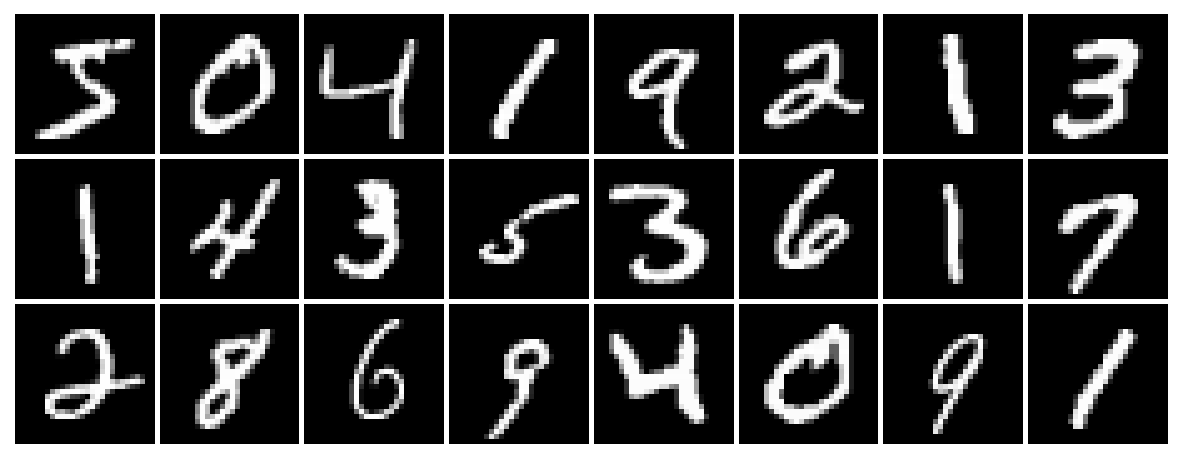

In [7]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(dim=1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


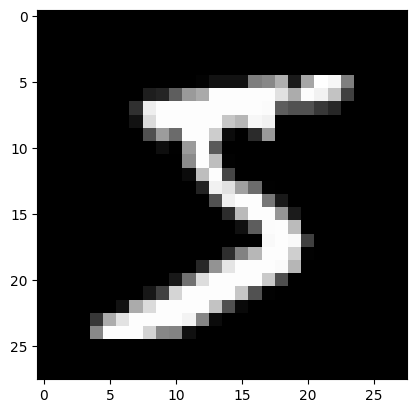

In [8]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy(), cmap='gray')
print('class:', target)

## Modelo

In [9]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [10]:
xin = x_train[:5].view(-1,28*28)
score = model(Variable(xin))
score

tensor([[ 0.1229,  0.0288,  0.3180,  0.0095,  0.1147, -0.1114,  0.2850,  0.3233,
         -0.1708,  0.2979],
        [ 0.0835, -0.1623,  0.2310, -0.0595, -0.1052,  0.1147,  0.3423, -0.1554,
         -0.1442, -0.0086],
        [-0.0879,  0.0865,  0.0975, -0.1510, -0.2792,  0.2024,  0.1944, -0.1399,
          0.2130, -0.1444],
        [ 0.3985, -0.0094,  0.1462,  0.0332, -0.3388, -0.2749,  0.0733, -0.0938,
         -0.0504, -0.0494],
        [-0.0511,  0.0919,  0.2785,  0.1167, -0.0906, -0.0638, -0.0093, -0.0992,
          0.0411,  0.0824]], grad_fn=<AddmmBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [11]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [12]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-wnize3be
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-wnize3be
  Resolved https://github.com/szagoruyko/pytorchviz to commit 5cf04c13e601366f6b9cf5939b5af5144d55b887
  Preparing metadata (setup.py) ... done


In [13]:
from torchviz import make_dot, make_dot_from_trace
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
loss


tensor(2.3226, grad_fn=<NllLossBackward0>)

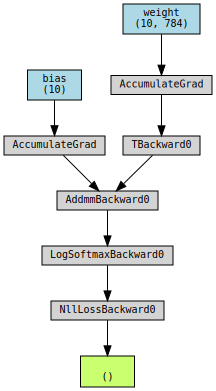

In [14]:
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [15]:
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()


In [16]:
print('Final loss:', loss.item())

Final loss: 0.26415467262268066


### Visualizando gráfico de perda durante o treinamento

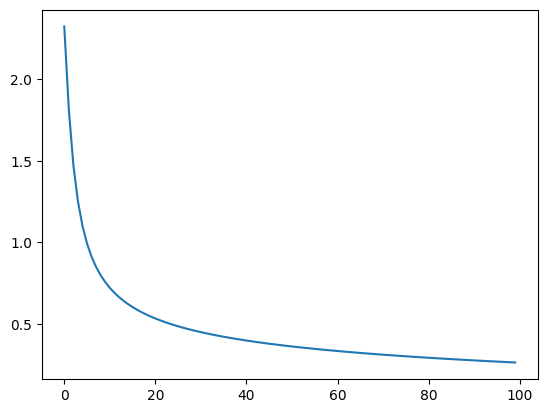

In [17]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [18]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.941


### Matriz de confusão com dados de treinamento e teste

In [19]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,96,0,1,0,0,0,1,0,0,2
1,0,110,1,0,0,0,2,3,1,0
2,0,1,91,1,0,1,0,1,2,1
3,0,0,0,88,0,2,0,0,0,0
4,0,0,1,0,102,2,1,2,0,3
5,0,2,0,1,0,82,0,0,1,1
6,1,0,1,1,2,2,90,0,1,0
7,0,1,1,1,0,0,0,110,0,3
8,0,2,2,0,0,1,0,0,82,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


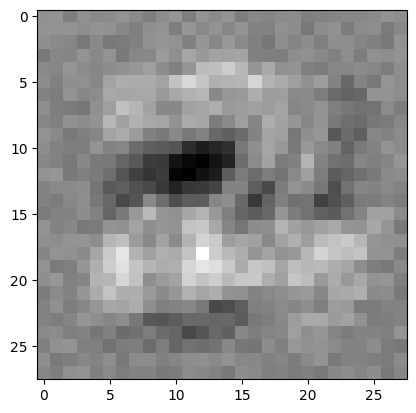

In [20]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[2, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

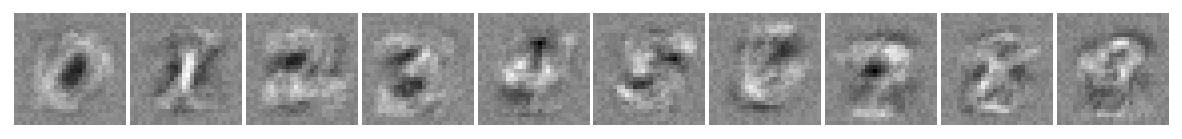

In [21]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

In [22]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [23]:
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    # verbose
    if (i+1) % 5 == 0:
        print('Epoch[{}/{}] - loss: {:.6f} - accuracy: {:.6f}'
              .format(i+1, epochs, loss.data, accuracy))

Epoch[5/100] - loss: 1.100793 - accuracy: 0.813000
Epoch[10/100] - loss: 0.754440 - accuracy: 0.853000
Epoch[15/100] - loss: 0.619878 - accuracy: 0.871000
Epoch[20/100] - loss: 0.543738 - accuracy: 0.884000
Epoch[25/100] - loss: 0.492771 - accuracy: 0.893000
Epoch[30/100] - loss: 0.455280 - accuracy: 0.901000
Epoch[35/100] - loss: 0.425992 - accuracy: 0.907000
Epoch[40/100] - loss: 0.402144 - accuracy: 0.910000
Epoch[45/100] - loss: 0.382129 - accuracy: 0.914000
Epoch[50/100] - loss: 0.364940 - accuracy: 0.916000
Epoch[55/100] - loss: 0.349912 - accuracy: 0.921000
Epoch[60/100] - loss: 0.336581 - accuracy: 0.927000
Epoch[65/100] - loss: 0.324616 - accuracy: 0.929000
Epoch[70/100] - loss: 0.313773 - accuracy: 0.929000
Epoch[75/100] - loss: 0.303866 - accuracy: 0.932000
Epoch[80/100] - loss: 0.294750 - accuracy: 0.935000
Epoch[85/100] - loss: 0.286314 - accuracy: 0.938000
Epoch[90/100] - loss: 0.278466 - accuracy: 0.939000
Epoch[95/100] - loss: 0.271133 - accuracy: 0.940000
Epoch[100/100

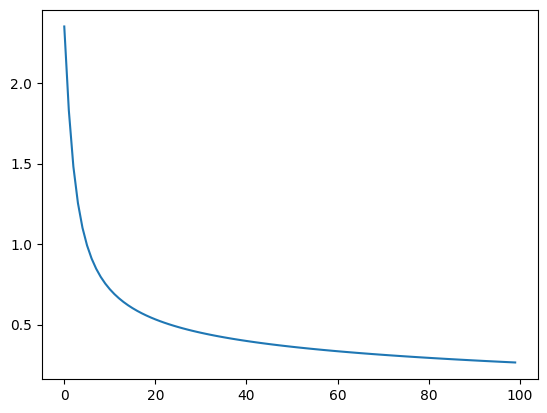

In [24]:
plt.plot(losses)

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

In [25]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

grad_w4_norms = []
grad_b4_values = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()

    # gradientes dos pesos da classe 4
    grad_w_4 = model.weight.grad[4]
    # gradiente do bias da classe 4
    grad_b_4 = model.bias.grad[4]

    grad_w4_norms.append(grad_w_4.norm().item())
    grad_b4_values.append(grad_b_4.item())

    optimizer.step()

    # verbose
    if (i+1) % 10 == 0:
      print(f"\nÉpoca {i+1}")
      print("Bias da classe 4:", grad_b_4.item())
      print("8 primeros pesos da classe 4:", grad_w_4[-10:].tolist())


Época 10
Bias da classe 4: -0.0038580838590860367
8 primeros pesos da classe 4: [0.00019050999253522605, 7.805254426784813e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Época 20
Bias da classe 4: -0.0024689387064427137
8 primeros pesos da classe 4: [0.00016466612578369677, 7.28875384083949e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Época 30
Bias da classe 4: -0.001808468485251069
8 primeros pesos da classe 4: [0.00014641968300566077, 6.734155613230541e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Época 40
Bias da classe 4: -0.0014047635486349463
8 primeros pesos da classe 4: [0.00013342031161300838, 6.27227418590337e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Época 50
Bias da classe 4: -0.001124235917814076
8 primeros pesos da classe 4: [0.00012359724496491253, 5.8905105106532574e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Época 60
Bias da classe 4: -0.000915065873414278
8 primeros pesos da classe 4: [0.00011585289030335844, 5.571382644120604e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

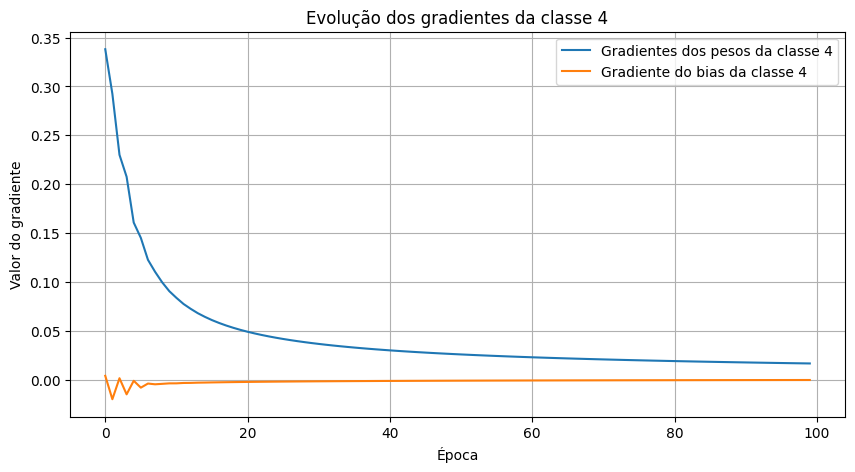

In [26]:
plt.figure(figsize=(10,5))
plt.plot(grad_w4_norms, label="Gradientes dos pesos da classe 4")
plt.plot(grad_b4_values, label="Gradiente do bias da classe 4")
plt.xlabel("Época")
plt.ylabel("Valor do gradiente")
plt.title("Evolução dos gradientes da classe 4")
plt.legend()
plt.grid(True)
plt.show()